**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/NTC.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date  Open  High  Low  Close  Volume  Earnings Yield (EY)  \
0 1999-01-01    93    97   91     93       0                 14.4   
1 1999-01-04    93    95   90     91  253844                 14.7   
2 1999-01-05    91   100   91     93  539893                 14.4   
3 1999-01-06    93    97   92     93  421166                 14.4   
4 1999-01-07    93    93   92     92  865619                 14.6   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0                  1.1         6.944444      -           -   
1                  1.1         6.802721      -           -   
2                  1.1         6.944444      -           -   
3                  1.1         6.944444      -           -   
4                  1.1         6.849315      -           -   

   Total Return Index (TRI)  
0                      73.0  
1                      71.0  
2                      73.0  
3                      73.0  
4                      72.0

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11 -0.023811  0.000000  0.011834  0.000000  0.000000 -0.011696   
2000-05-12 -0.024098 -0.023530 -0.011834  0.000000 -0.011834 -0.011834   
2000-05-15 -0.048790 -0.011834  0.000000 -0.011834  0.000000 -0.011834   
2000-05-16 -0.048790 -0.011834  0.000000  0.000000 -0.011834  0.000000   
2000-05-17 -0.125163  0.011834  0.011834  0.011834  0.011834  0.000000   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11 -0.045754 -0.031247 -0.004449  -0.025528  ...     -0.068993   
2000-05-12 -0.041368 -0.028675 -0.014899  -0.025165  ...      0.000000   
2000-05-15 -0.032303 -0.023061 -0.024179  -0.022741  ...     -0.023530   
2000-05-16 -0.023238 -0.019319 -0.031078  -0.020758  ...     -0.011834   
2000-05-17 -0.007073 -0.008935 -0.031012  -0.014832  ...     -0.011834   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11    -0.011834     -0.057158          -0.057158          0.000000   
2000-05-12    -0.011834     -0.011696           0.000000          0.000000   
2000-05-15    -0.023811     -0.046520          -0.023530         -0.011834   
2000-05-16    -0.048202     -0.011696           0.000000          0.000000   
2000-05-17    -0.011976      0.000000           0.000000          0.011834   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11            0.000000           -0.057158           0.000000   
2000-05-12           -0.011696           -0.011834          -0.011834   
2000-05-15           -0.011834           -0.023530          -0.011834   
2000-05-16            0.000000           -0.011834          -0.011834   
2000-05-17            0.011834            0.000000           0.011834   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11           -0.057158         -0.011834  
2000-05-12           -0.023530          0.000000  
2000-05-15           -0.046520         -0.011834  
2000-05-16           -0.023530         -0.011834  
2000-05-17            0.000000          0.000000  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.003012468367865806
  dropout = 0.15943317135049292
  units = 256
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 23
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.001103899444729186
RMSE = 0.03322498223820723
MAE = 0.02532127399339276
R-Squared = 0.2590404861937756

Results on Validation set: 
MSE = 0.0014214120575941935
RMSE = 0.03770161876623063
MAE = 0.02654595274552614
R-Squared = -0.08042991628113483

Results on Testing set: 
MSE = 0.0007504322896411379
RMSE = 0.027394019231232532
MAE = 0.02217857663005409
R-Squared = -0.04373161207017451



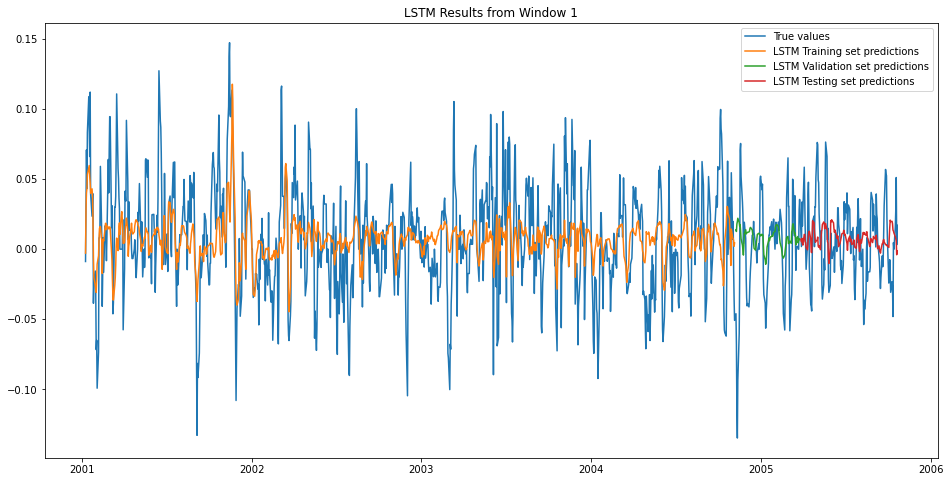

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0013418262955115132
RMSE = 0.036630947237431814
MAE = 0.028049388927000613
R-Squared = 0.06498791882620147

Results on Validation set: 
MSE = 0.0005469662384017537
RMSE = 0.023387309345064767
MAE = 0.019152868353144704
R-Squared = 0.025615960541588212

Results on Testing set: 
MSE = 0.00134218966225872
RMSE = 0.03663590673449642
MAE = 0.02899148225122302
R-Squared = -0.018409015356443126



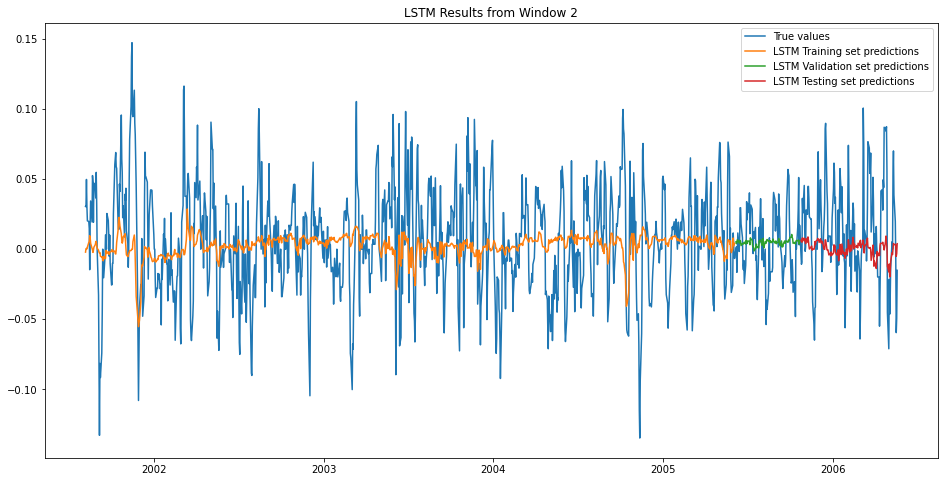

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0011598482920149302
RMSE = 0.034056545509122474
MAE = 0.02636296510431724
R-Squared = 0.059592251617947345

Results on Validation set: 
MSE = 0.0013427265573485757
RMSE = 0.03664323344559778
MAE = 0.0297814941809585
R-Squared = 0.09469946242284555

Results on Testing set: 
MSE = 0.002116760189103405
RMSE = 0.04600826218304061
MAE = 0.03290435944148439
R-Squared = -0.27318337854723485



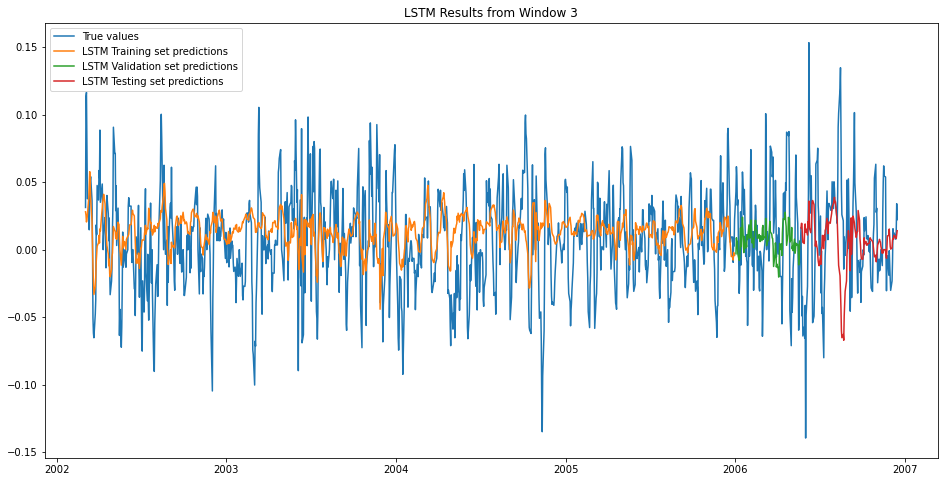

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0012154120377800583
RMSE = 0.03486276004248743
MAE = 0.027005417030825322
R-Squared = 0.04408220012467601

Results on Validation set: 
MSE = 0.0014643771198246311
RMSE = 0.03826718071434883
MAE = 0.02733931337904841
R-Squared = -0.21523299485684477

Results on Testing set: 
MSE = 0.001499827584907288
RMSE = 0.03872760752883256
MAE = 0.03132658857994386
R-Squared = 0.01578878539845796



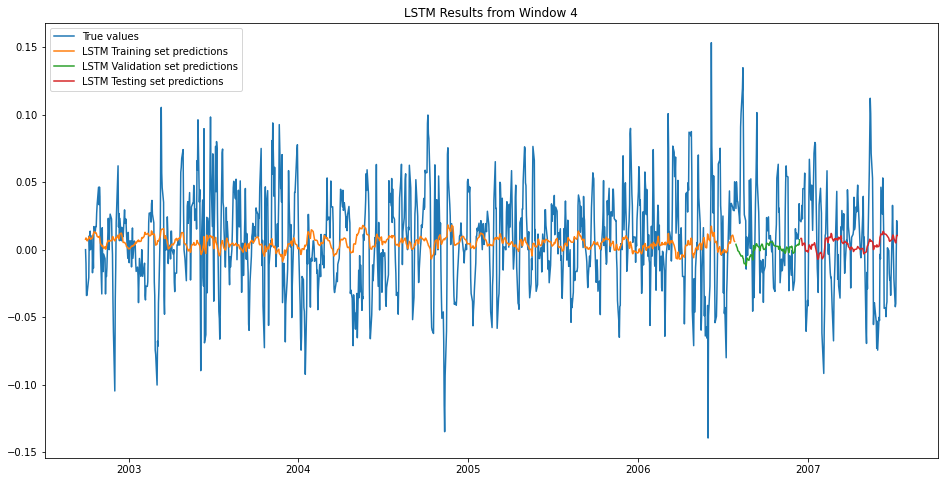

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.000866520546590262
RMSE = 0.029436721057044753
MAE = 0.021532041062845623
R-Squared = 0.3530597365737972

Results on Validation set: 
MSE = 0.0011301949057503024
RMSE = 0.033618371551137075
MAE = 0.02695421991868765
R-Squared = 0.1641828857266826

Results on Testing set: 
MSE = 0.004071922481480022
RMSE = 0.06381161713575376
MAE = 0.05154975517838821
R-Squared = -1.26134879805652



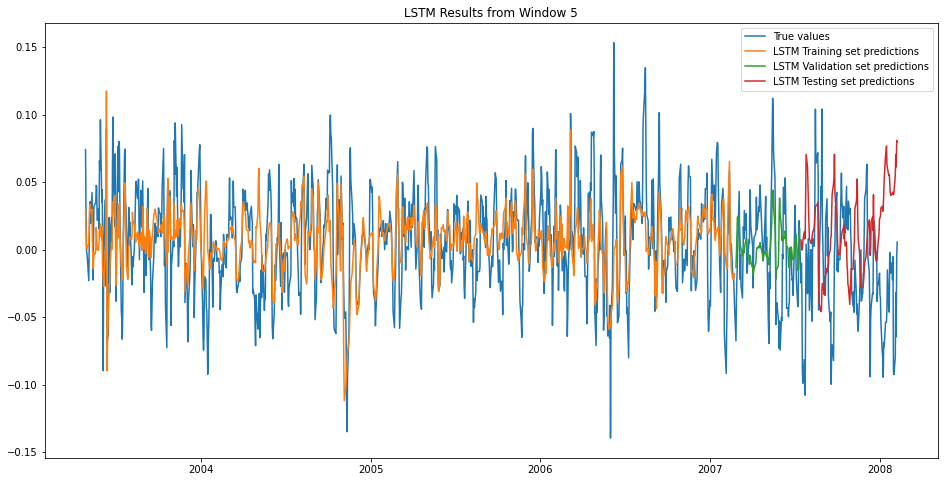

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0004209835621982748
RMSE = 0.020517883960054818
MAE = 0.015319234207794196
R-Squared = 0.7017697461234689

Results on Validation set: 
MSE = 0.0018437566624739013
RMSE = 0.042938987674069604
MAE = 0.03277733328091883
R-Squared = -0.33739979405809906

Results on Testing set: 
MSE = 0.002674532375630758
RMSE = 0.05171588127094769
MAE = 0.041002088177850504
R-Squared = -0.30965979569471846



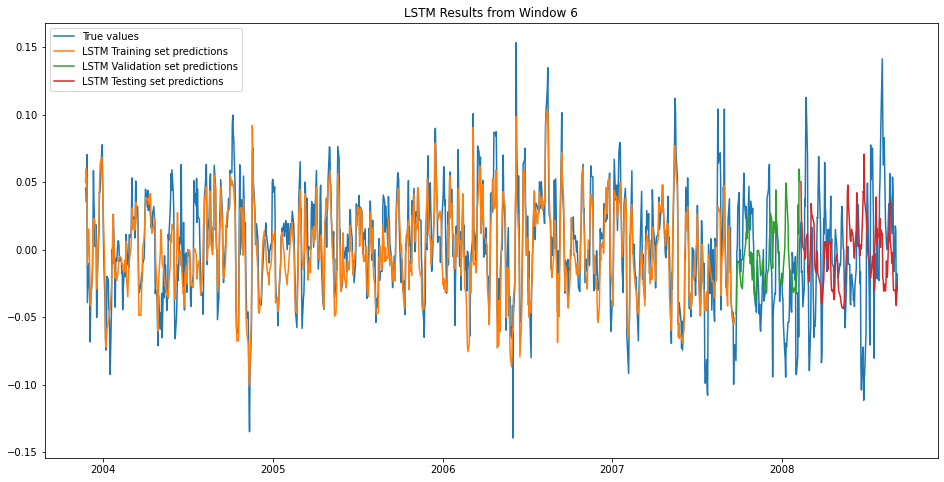

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0014379694004622964
RMSE = 0.037920566984979226
MAE = 0.029650286011020485
R-Squared = 0.03945289490541026

Results on Validation set: 
MSE = 0.0022217602249783607
RMSE = 0.047135551603628874
MAE = 0.03468758507310511
R-Squared = -0.0790888445185054

Results on Testing set: 
MSE = 0.004180283377729525
RMSE = 0.06465511099464237
MAE = 0.05256015078370336
R-Squared = -0.00541855944584535



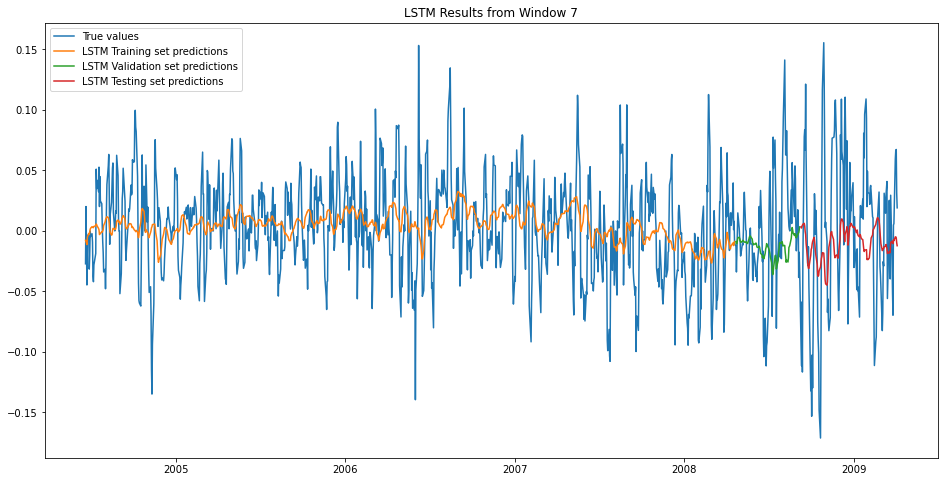

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0016371463816401528
RMSE = 0.040461665581636067
MAE = 0.03087924904057508
R-Squared = 0.10109081201135317

Results on Validation set: 
MSE = 0.0027980268112205854
RMSE = 0.05289637805389501
MAE = 0.04289570292405637
R-Squared = -0.052505624734698664

Results on Testing set: 
MSE = 0.0015135194178049918
RMSE = 0.03890397688932318
MAE = 0.030237357464633602
R-Squared = -0.07150331126221121



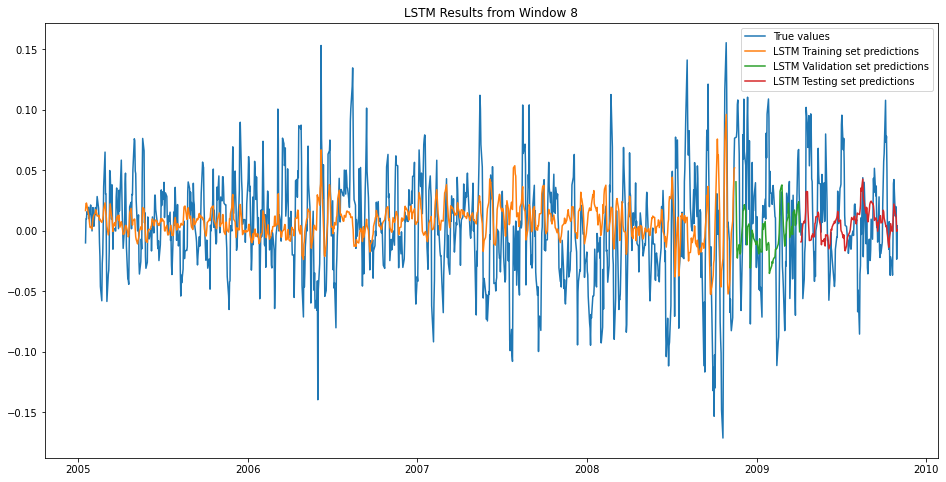

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.001645296829740364
RMSE = 0.0405622586863745
MAE = 0.03115058255826789
R-Squared = 0.20968523618479085

Results on Validation set: 
MSE = 0.0012766146824215719
RMSE = 0.03572974506516345
MAE = 0.025910106356900702
R-Squared = -0.052360734828940325

Results on Testing set: 
MSE = 0.0008902844984577993
RMSE = 0.02983763560434706
MAE = 0.023529829830327247
R-Squared = -0.32535380079588094



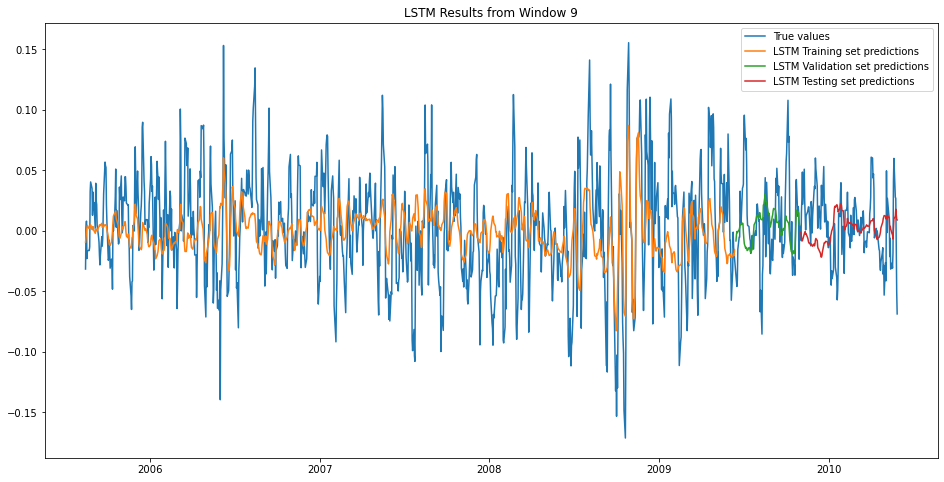

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0018271124212148485
RMSE = 0.042744735596501805
MAE = 0.03303140156075497
R-Squared = 0.12472751495733914

Results on Validation set: 
MSE = 0.0006640111586350511
RMSE = 0.025768413972052123
MAE = 0.01969416740560089
R-Squared = 0.017888037795468104

Results on Testing set: 
MSE = 0.000634824597871699
RMSE = 0.025195725785769677
MAE = 0.02014434241674644
R-Squared = -0.03109577401435204



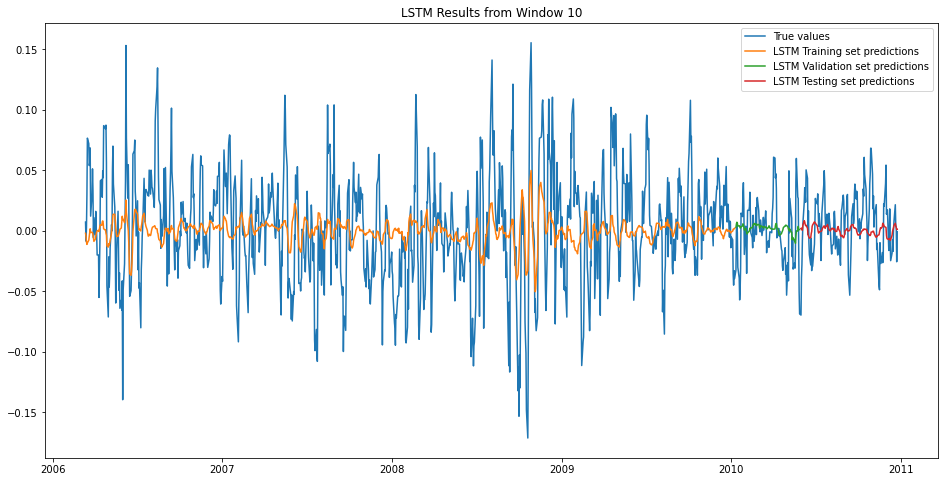

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0013400554767102229
RMSE = 0.03660676818172048
MAE = 0.027778411992161932
R-Squared = 0.2786406380261822

Results on Validation set: 
MSE = 0.0006579293524643427
RMSE = 0.025650133575955168
MAE = 0.020280051170171655
R-Squared = -0.05755667972918599

Results on Testing set: 
MSE = 0.0004409153446875871
RMSE = 0.020997984300584357
MAE = 0.0161786451577841
R-Squared = -0.3386225353501904



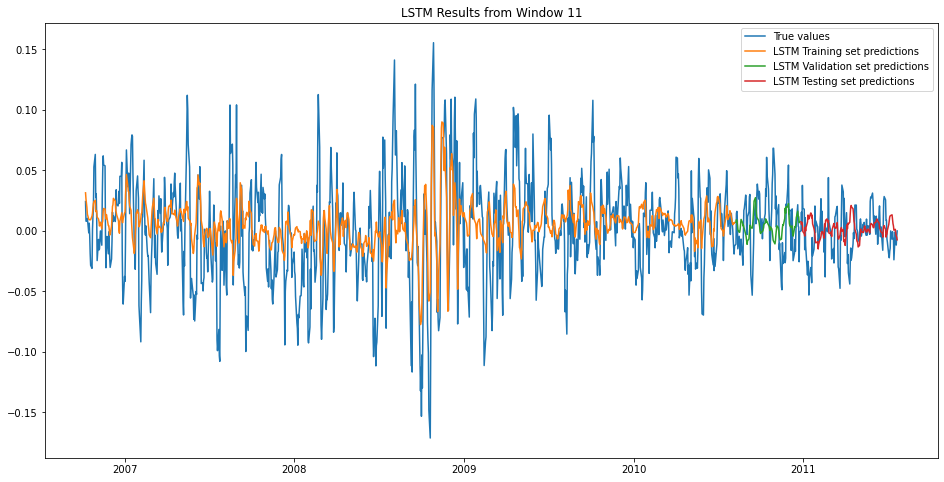

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0015856937099099347
RMSE = 0.03982076983070436
MAE = 0.02972490278430329
R-Squared = 0.11358941635718023

Results on Validation set: 
MSE = 0.00029042757865343767
RMSE = 0.01704193588338595
MAE = 0.012973894257364149
R-Squared = -0.03155584423845825

Results on Testing set: 
MSE = 0.000688814028740779
RMSE = 0.02624526678738052
MAE = 0.02051378639771638
R-Squared = 0.04504705354335237



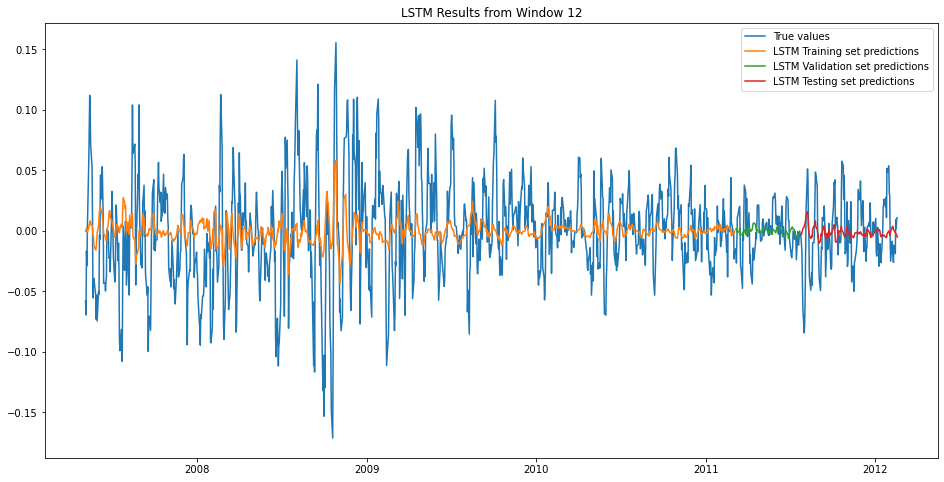

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0014479813823125662
RMSE = 0.038052350549112816
MAE = 0.027851262568029136
R-Squared = 0.07946058558059887

Results on Validation set: 
MSE = 0.0005024562354283959
RMSE = 0.02241553558201088
MAE = 0.01789067898132405
R-Squared = 0.06674348620212711

Results on Testing set: 
MSE = 0.0006285240811297405
RMSE = 0.025070382548532052
MAE = 0.018126943830337014
R-Squared = -0.41971202236418836



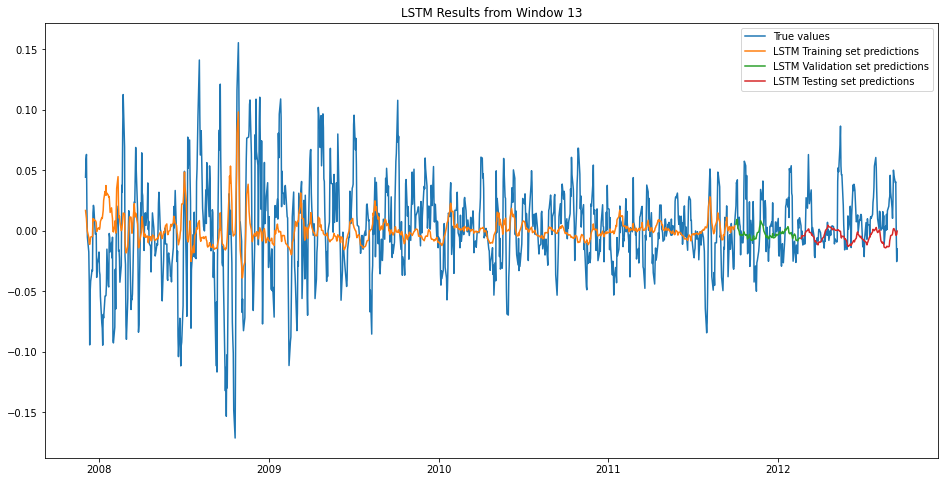

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0005411405937124941
RMSE = 0.0232624288008044
MAE = 0.017472732882838293
R-Squared = 0.5936752468643737

Results on Validation set: 
MSE = 0.000552544503289899
RMSE = 0.023506265192282227
MAE = 0.017111479384517986
R-Squared = -0.16431781266299894

Results on Testing set: 
MSE = 0.0007009589974438578
RMSE = 0.02647563025583825
MAE = 0.021376850280984384
R-Squared = -0.36649812277581906



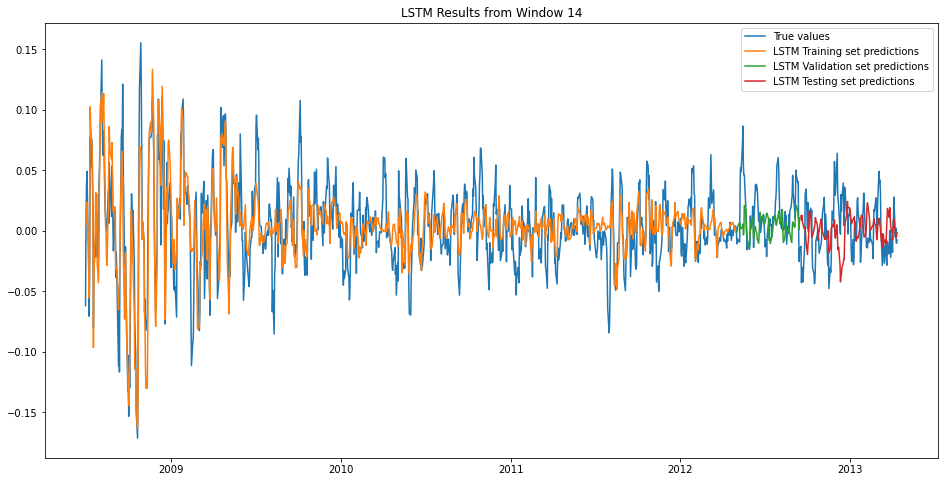

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0007379553720710983
RMSE = 0.027165334013611875
MAE = 0.020202398923923257
R-Squared = 0.0800267295031496

Results on Validation set: 
MSE = 0.00045583558587240823
RMSE = 0.02135030645851268
MAE = 0.01739356615625954
R-Squared = -0.008284111684758955

Results on Testing set: 
MSE = 0.001073406135537125
RMSE = 0.032762877400147945
MAE = 0.02477618947708781
R-Squared = -0.008094773977137093



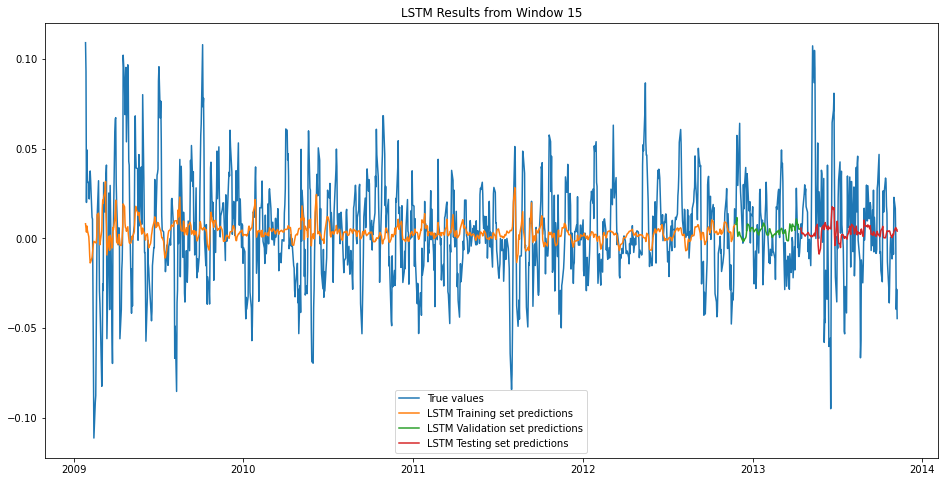

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0005946020574771711
RMSE = 0.024384463444520797
MAE = 0.018317266984248064
R-Squared = 0.09529404230142058

Results on Validation set: 
MSE = 0.000639070221009979
RMSE = 0.025279838231483585
MAE = 0.0202338992251406
R-Squared = 0.09991145773322929

Results on Testing set: 
MSE = 0.0013945480989599633
RMSE = 0.03734364870978683
MAE = 0.02825256638298896
R-Squared = -0.17043269258119098



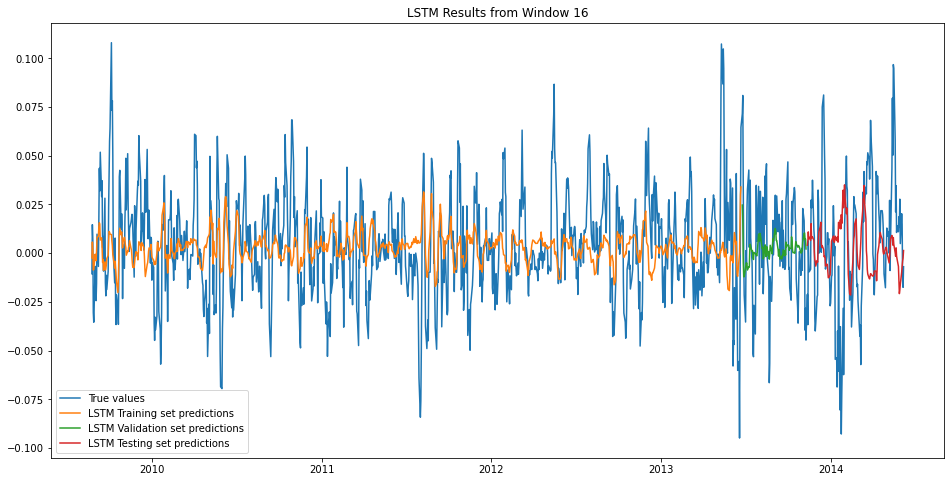

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.00047264769688295816
RMSE = 0.021740462204906275
MAE = 0.015925737469837293
R-Squared = 0.2958853949033309

Results on Validation set: 
MSE = 0.0015504398003118275
RMSE = 0.03937562444345267
MAE = 0.027827100653725848
R-Squared = -0.2523874935714563

Results on Testing set: 
MSE = 0.0008280681728652716
RMSE = 0.02877617370091569
MAE = 0.021337528224254235
R-Squared = -0.1710594750702079



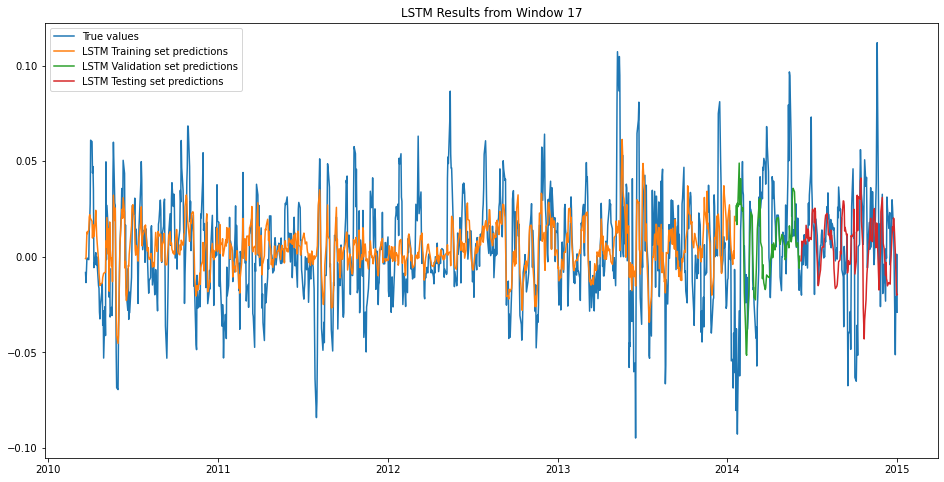

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0007132929316466912
RMSE = 0.02670754447055534
MAE = 0.019936545391375324
R-Squared = -0.0038966548575383175

Results on Validation set: 
MSE = 0.0009480759990471188
RMSE = 0.030790842779097796
MAE = 0.023272195572944365
R-Squared = -0.037185793270668066

Results on Testing set: 
MSE = 0.0007796742635160025
RMSE = 0.02792264786004369
MAE = 0.021683085974689112
R-Squared = -0.003929444941082272



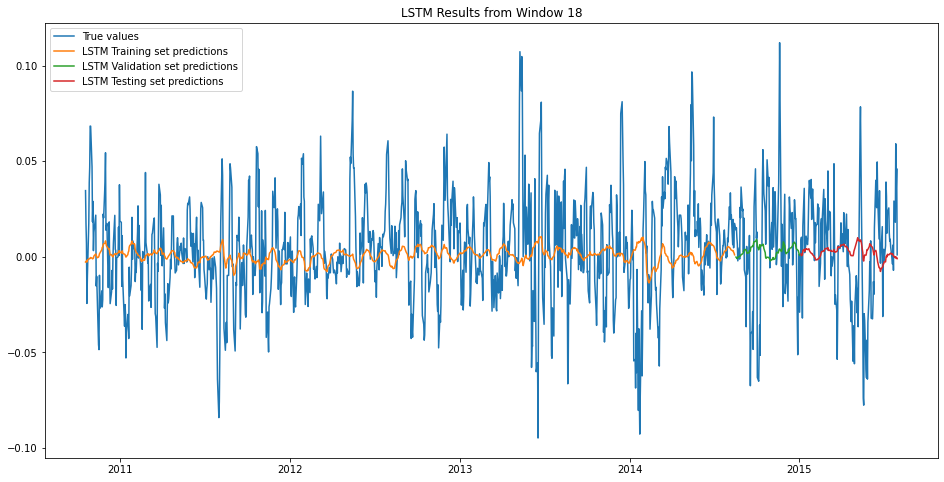

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0006822958281371022
RMSE = 0.02612079302274535
MAE = 0.019033970036196463
R-Squared = 0.07454615877019843

Results on Validation set: 
MSE = 0.000956551145044272
RMSE = 0.0309281610356043
MAE = 0.02404068170056064
R-Squared = -0.0006665356404886857

Results on Testing set: 
MSE = 0.0015039915222574024
RMSE = 0.03878132955762866
MAE = 0.030899914174014012
R-Squared = -0.06262825201021105



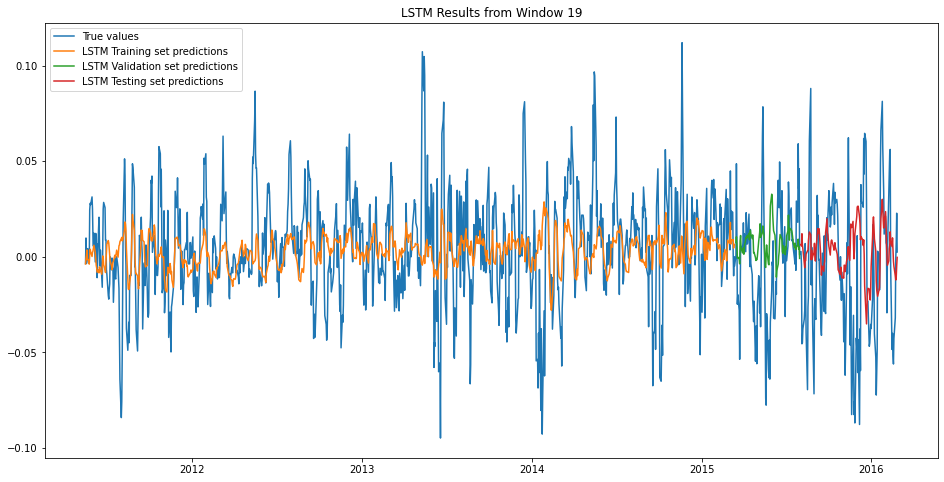

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0007208852834283741
RMSE = 0.026849306945028843
MAE = 0.019993971052828647
R-Squared = 0.08792198604866497

Results on Validation set: 
MSE = 0.0015767361063870164
RMSE = 0.03970813652624631
MAE = 0.033296294523489915
R-Squared = 0.03272770410481052

Results on Testing set: 
MSE = 0.0011082339898089721
RMSE = 0.033290148539905494
MAE = 0.026256189070026574
R-Squared = -0.13509629363732745



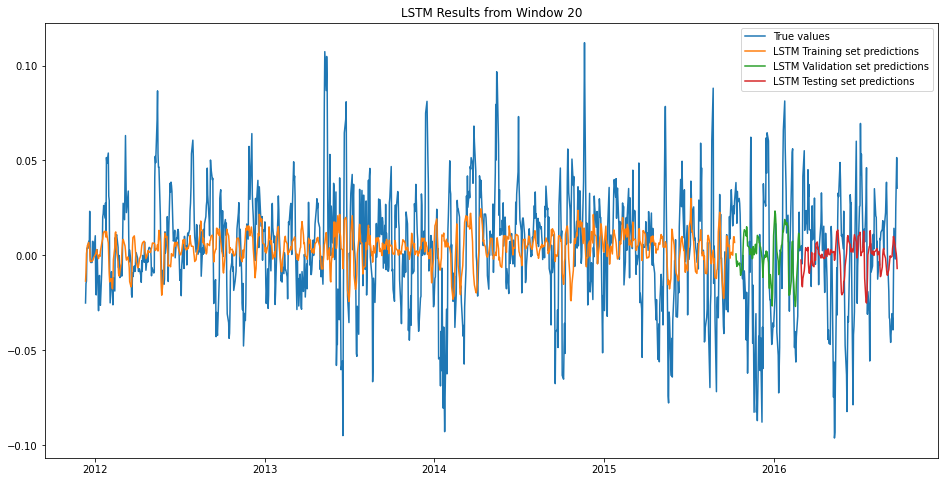

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0007675731384775539
RMSE = 0.02770511033144524
MAE = 0.020956019997778737
R-Squared = 0.16939175677100815

Results on Validation set: 
MSE = 0.0010555003157360727
RMSE = 0.032488464348689565
MAE = 0.024688990179404444
R-Squared = 0.11764759177767325

Results on Testing set: 
MSE = 0.0019572266343130165
RMSE = 0.04424055418180266
MAE = 0.03238673179500341
R-Squared = -0.16310652762331035



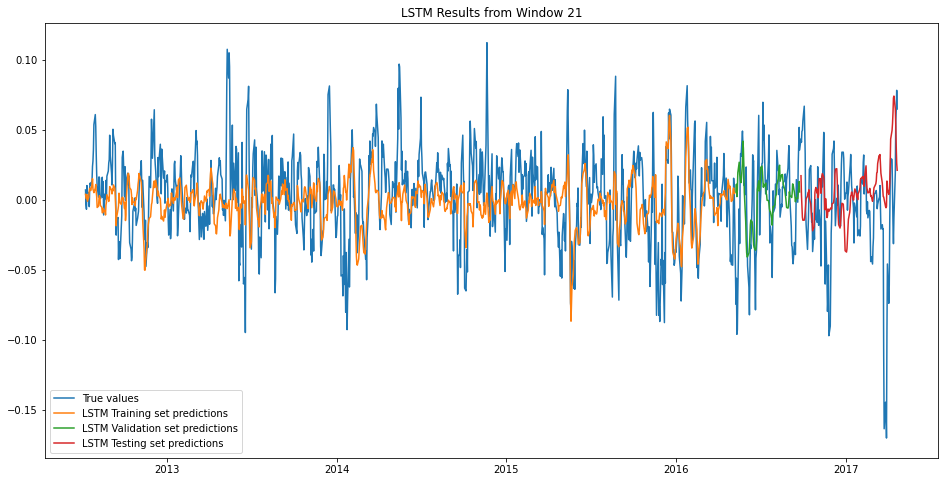

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0010294628388524245
RMSE = 0.032085243319202435
MAE = 0.02462188414279046
R-Squared = 0.013252688369900678

Results on Validation set: 
MSE = 0.001929054403672762
RMSE = 0.04392100185187904
MAE = 0.027095309767699912
R-Squared = -0.09583998949454986

Results on Testing set: 
MSE = 0.0011763875864351007
RMSE = 0.0342985070583998
MAE = 0.025049886059420823
R-Squared = -0.10182544554156325



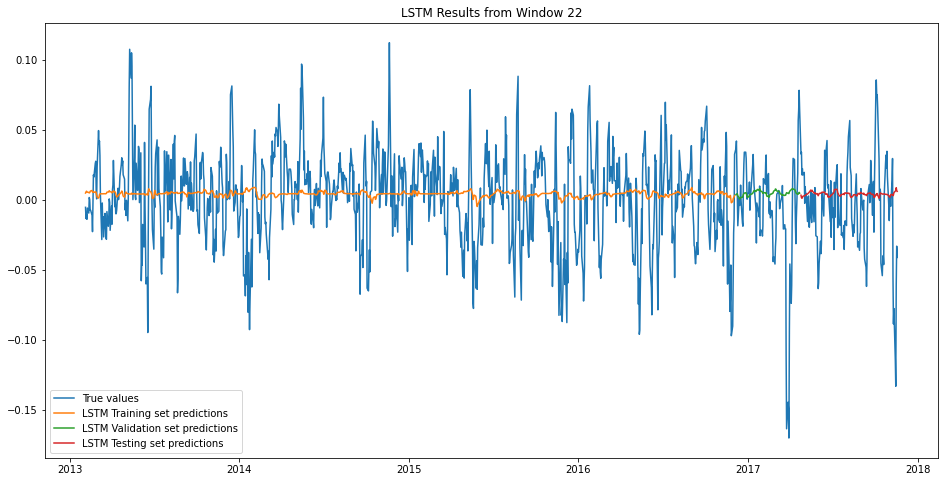

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0008854113596264917
RMSE = 0.029755862609349634
MAE = 0.02253709868568356
R-Squared = 0.19229306176867456

Results on Validation set: 
MSE = 0.001286390304609342
RMSE = 0.03586628367435553
MAE = 0.02627809810392344
R-Squared = 0.0287623172787852

Results on Testing set: 
MSE = 0.0012527547541093097
RMSE = 0.035394275725169316
MAE = 0.026236823889265615
R-Squared = -0.17149223830200055



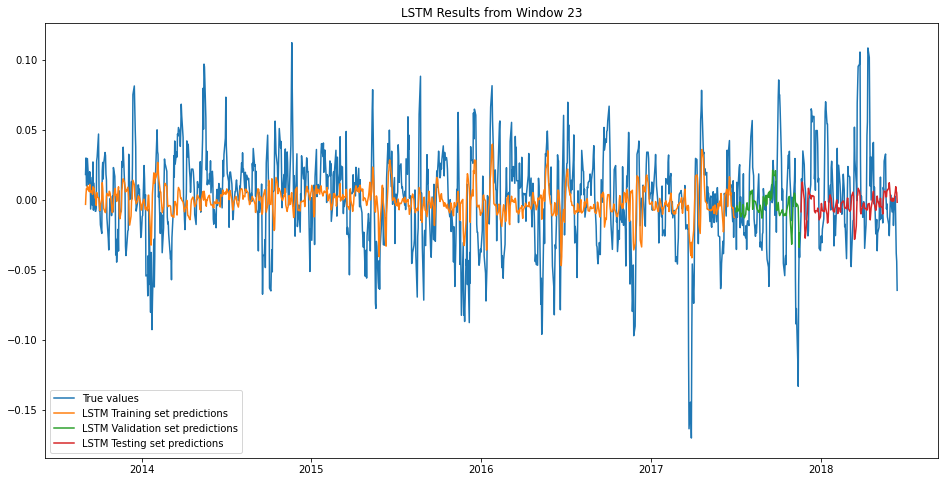

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0010604199725240614
RMSE = 0.03256409023025304
MAE = 0.024231172676895986
R-Squared = 0.06253133189765725

Results on Validation set: 
MSE = 0.001161768391590734
RMSE = 0.03408472372765744
MAE = 0.023615487122269845
R-Squared = -0.024011735797976552

Results on Testing set: 
MSE = 0.0013323585970392523
RMSE = 0.03650148760036024
MAE = 0.026888051566463636
R-Squared = 0.008152810043225989



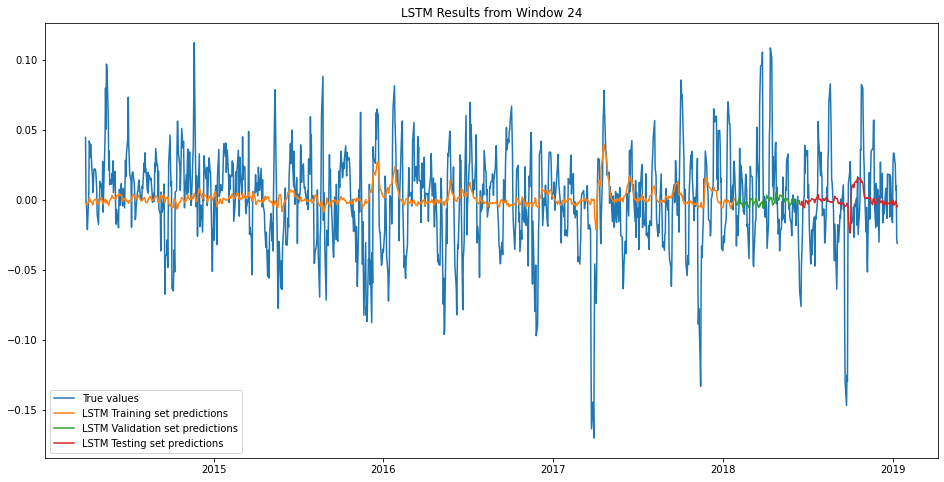

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4946

Results on Training set: 
MSE = 0.001185055046619603
RMSE = 0.034424628489202365
MAE = 0.02599922760542141
R-Squared = -0.00019461408267740232

Results on Validation set: 
MSE = 0.0013953374184351192
RMSE = 0.03735421553767552
MAE = 0.02571049472057482
R-Squared = 0.021759092162657256

Results on Testing set: 
MSE = 0.001954311872154556
RMSE = 0.04420759971039545
MAE = 0.031622474378787825
R-Squared = -0.03751050475380269



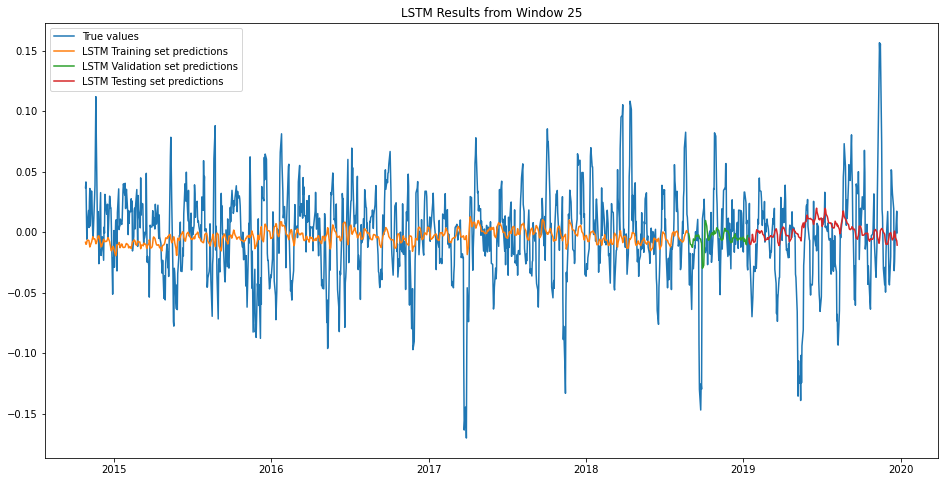

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 172
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.00014476706831299192
  dropout =  0.14726485363284803
  units = 203

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 166
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0014793387317868975
RMSE = 0.0384621727387689
MAE = 0.030200891953199086
R-Squared = 0.005864365410275019

Results on Validation set: 
MSE = 0.0007401055784275507
RMSE = 0.02720488151835164
MAE = 0.021810016011232523
R-Squared = 0.1392609485954761

Results on Testing set: 
MSE = 0.0006584657205371482
RMSE = 0.025660586909444377
MAE = 0.021195989791869287
R-Squared = 0.07690995252685273



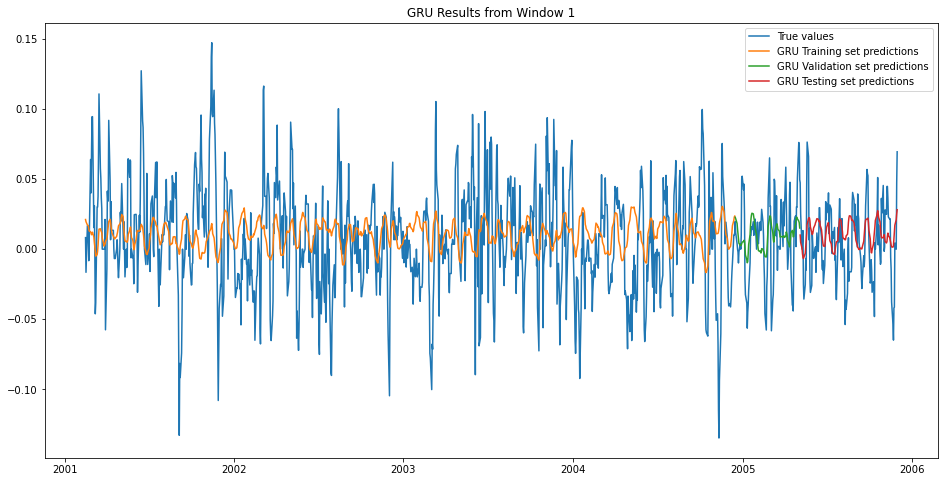

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0014142792965563542
RMSE = 0.037606904905301025
MAE = 0.02897159019019155
R-Squared = -0.030780632760029736

Results on Validation set: 
MSE = 0.000646412256456298
RMSE = 0.025424638767469206
MAE = 0.02063205238864701
R-Squared = 0.16479054724235487

Results on Testing set: 
MSE = 0.0018686155189670606
RMSE = 0.04322748568870344
MAE = 0.034135613877400654
R-Squared = -0.03994432009233484



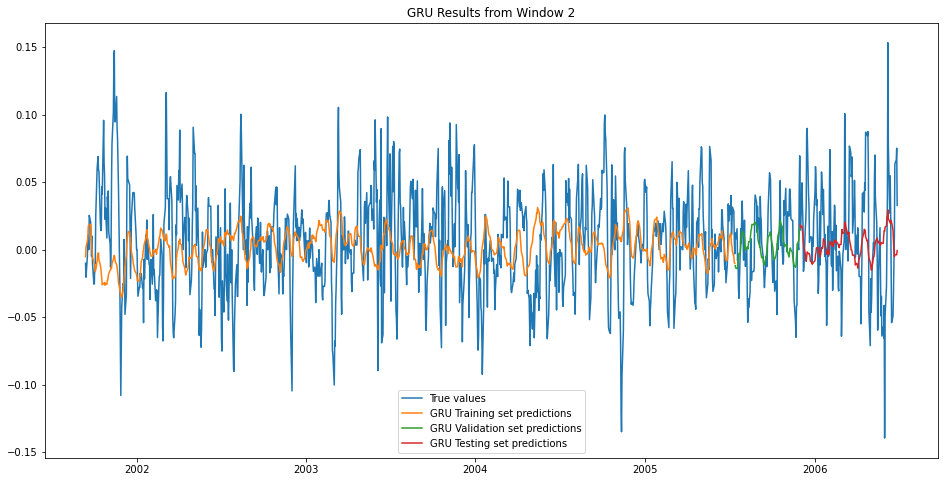

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0012129646480447244
RMSE = 0.034827642010976344
MAE = 0.027234274396224598
R-Squared = -0.020423047809909223

Results on Validation set: 
MSE = 0.002080608381994355
RMSE = 0.04561368634515692
MAE = 0.03629188139157411
R-Squared = 0.058523457851829774

Results on Testing set: 
MSE = 0.0014475834664776839
RMSE = 0.0380471216582501
MAE = 0.028035560207627507
R-Squared = -0.11384140459871728



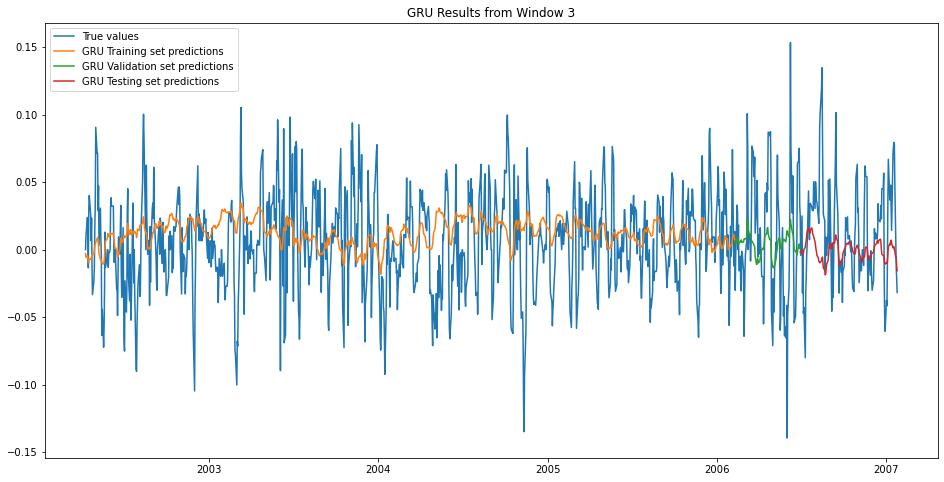

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0014173263007989164
RMSE = 0.0376473943427552
MAE = 0.02901407517973315
R-Squared = -0.068587435422506

Results on Validation set: 
MSE = 0.001032206159226111
RMSE = 0.03212796537638372
MAE = 0.023269285800191566
R-Squared = 0.03848673428911975

Results on Testing set: 
MSE = 0.0021171597032466744
RMSE = 0.04601260374339486
MAE = 0.03705260398972667
R-Squared = -0.23370527493855442



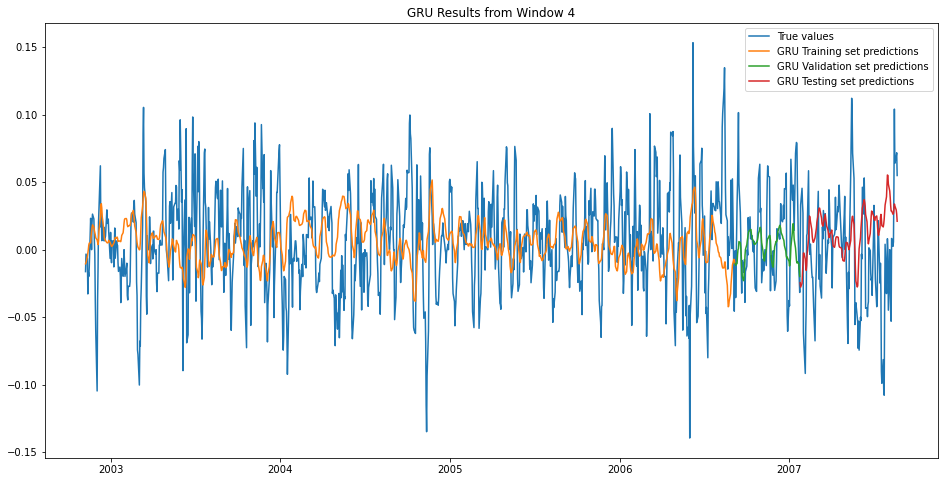

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.001299260199826497
RMSE = 0.03604525211212285
MAE = 0.028015677298060725
R-Squared = 0.020436776803448242

Results on Validation set: 
MSE = 0.0022877920146832154
RMSE = 0.04783086884725402
MAE = 0.03830320105331435
R-Squared = -0.11361061774589865

Results on Testing set: 
MSE = 0.0027630465190155227
RMSE = 0.052564688898684854
MAE = 0.043508216505620825
R-Squared = -0.6383810184241316



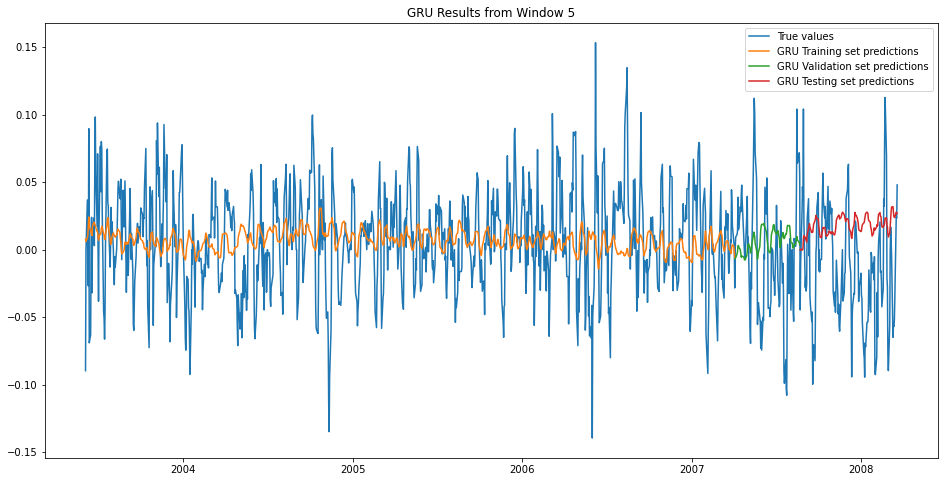

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0015298231619478649
RMSE = 0.03911295388931735
MAE = 0.030285804679549142
R-Squared = -0.10079514956237445

Results on Validation set: 
MSE = 0.0020944158286217733
RMSE = 0.045764788086713276
MAE = 0.0371591237746671
R-Squared = -0.3358315589893137

Results on Testing set: 
MSE = 0.00288004267373826
RMSE = 0.05366602904760385
MAE = 0.0405628126257199
R-Squared = -0.04735728796584704



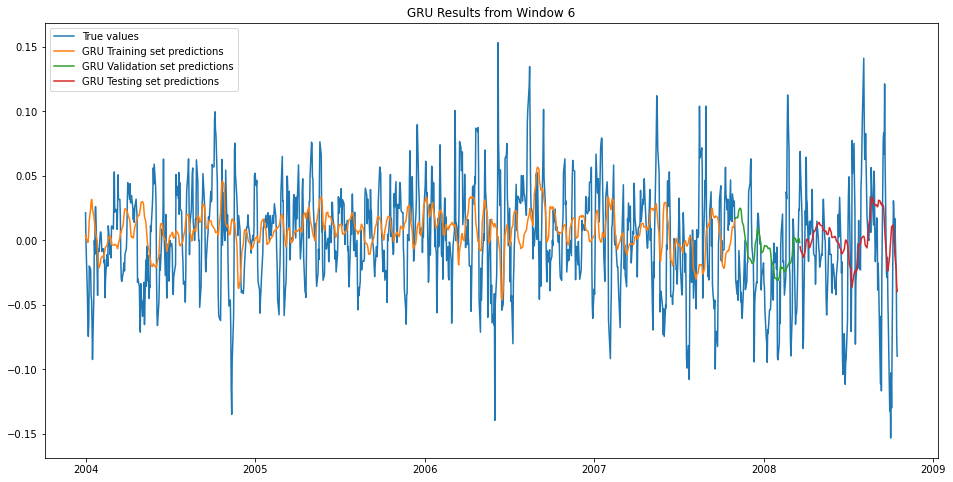

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0013860316719526606
RMSE = 0.037229446301988704
MAE = 0.02866648712489745
R-Squared = 0.07076272145880091

Results on Validation set: 
MSE = 0.003383709865685997
RMSE = 0.05816966447974405
MAE = 0.04679052027473268
R-Squared = 0.0724742621009069

Results on Testing set: 
MSE = 0.0032870129491696575
RMSE = 0.05733247726349924
MAE = 0.0471800604154569
R-Squared = 0.024648183784804045



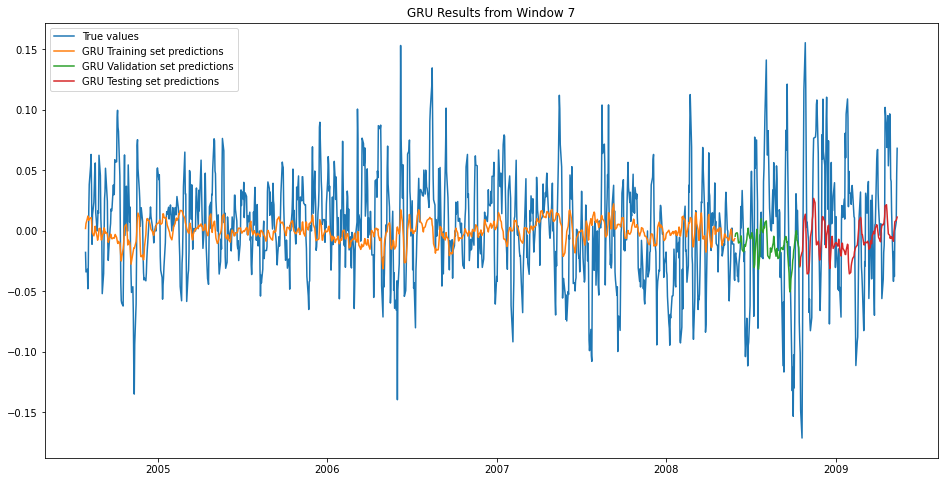

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0018339894843493764
RMSE = 0.04282510343652863
MAE = 0.032796796816519695
R-Squared = 0.04827069070332013

Results on Validation set: 
MSE = 0.0024244597911883465
RMSE = 0.049238803714025656
MAE = 0.03997377773610108
R-Squared = -0.058657843607758275

Results on Testing set: 
MSE = 0.001201957285469154
RMSE = 0.03466925562323417
MAE = 0.027331946751988873
R-Squared = -0.15094352088282026



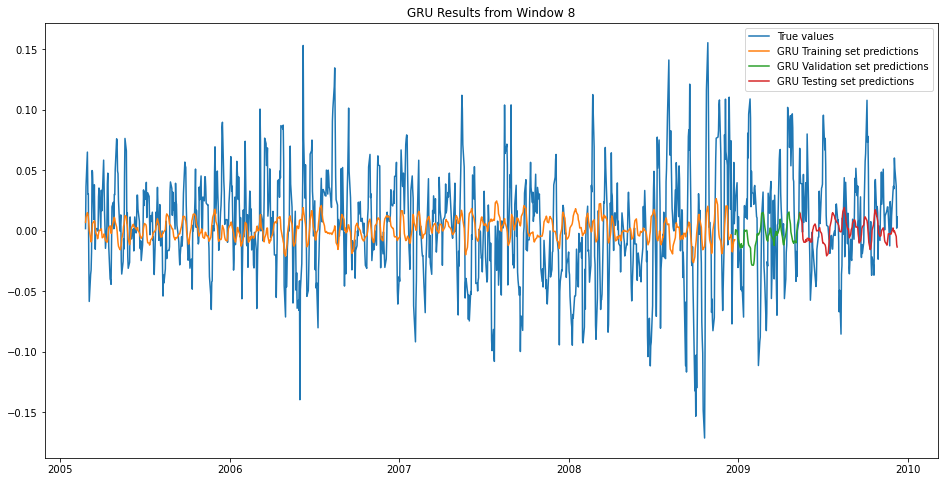

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0019666125014566496
RMSE = 0.04434650495198748
MAE = 0.034343671397464866
R-Squared = 0.0684629082027215

Results on Validation set: 
MSE = 0.0009232851110712068
RMSE = 0.030385606972236162
MAE = 0.02375371767796961
R-Squared = 0.023442590780511585

Results on Testing set: 
MSE = 0.0007188222452807968
RMSE = 0.026810860584486968
MAE = 0.020890478054157575
R-Squared = -0.03574244910307889



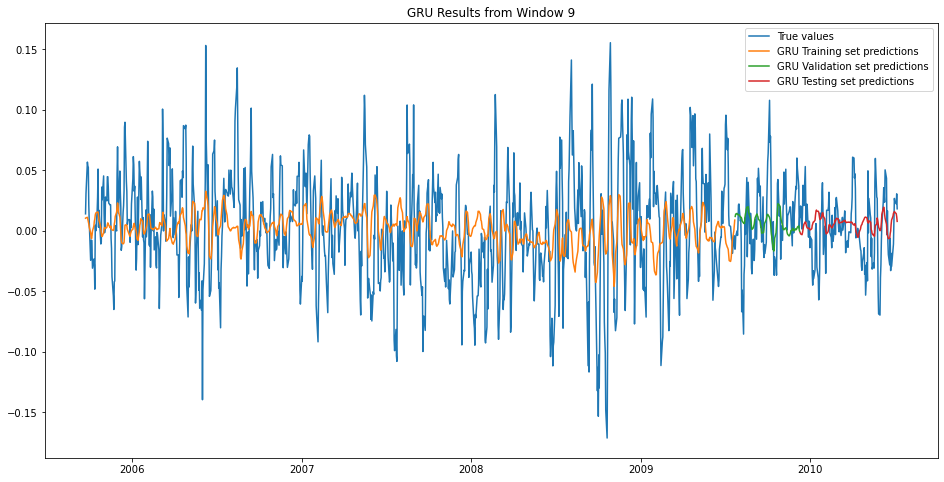

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0019826857284221838
RMSE = 0.044527359324601584
MAE = 0.0345299449287928
R-Squared = 0.041290530193339725

Results on Validation set: 
MSE = 0.0006688278795385386
RMSE = 0.025861706817968115
MAE = 0.019193289060199892
R-Squared = 0.07194357594793677

Results on Testing set: 
MSE = 0.0007698147193194128
RMSE = 0.02774553512404136
MAE = 0.022105161620742636
R-Squared = -0.30772937696990477



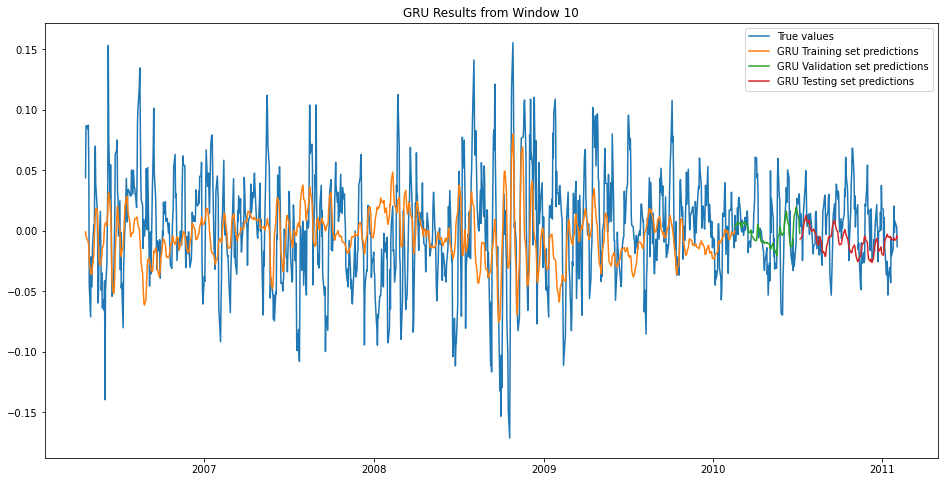

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0018219629650959896
RMSE = 0.04268445812114744
MAE = 0.03239550748412584
R-Squared = 0.017668200576295923

Results on Validation set: 
MSE = 0.0007014540723564785
RMSE = 0.026484978239682933
MAE = 0.0212899315371763
R-Squared = -0.06271442267389715

Results on Testing set: 
MSE = 0.0005234377215461596
RMSE = 0.022878761363897295
MAE = 0.016589960836844223
R-Squared = -0.03500215573430254



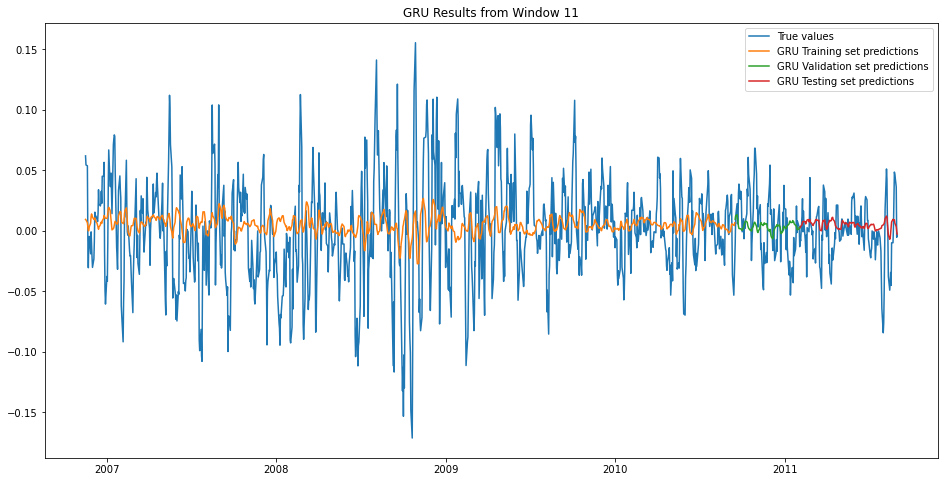

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0015969558797519893
RMSE = 0.03996193038070095
MAE = 0.030126287728803797
R-Squared = 0.06967170947984791

Results on Validation set: 
MSE = 0.0004335631047194782
RMSE = 0.02082217819344264
MAE = 0.014772256324318967
R-Squared = 0.2115523668815329

Results on Testing set: 
MSE = 0.000585233295562012
RMSE = 0.02419159555634998
MAE = 0.018336803549036305
R-Squared = -0.11045653863679283



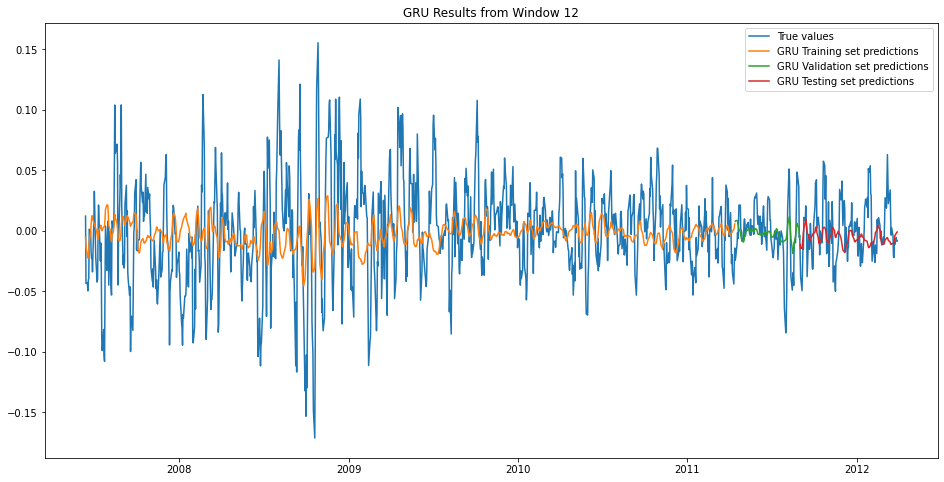

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0014514578010755164
RMSE = 0.03809800258642855
MAE = 0.027825010723094172
R-Squared = 0.05358945637993495

Results on Validation set: 
MSE = 0.0005911374084083168
RMSE = 0.0243133175113623
MAE = 0.018027836602703632
R-Squared = -0.23166422292128774

Results on Testing set: 
MSE = 0.0007908316427454778
RMSE = 0.028121729014153413
MAE = 0.021656275154638256
R-Squared = -0.5089235977464794



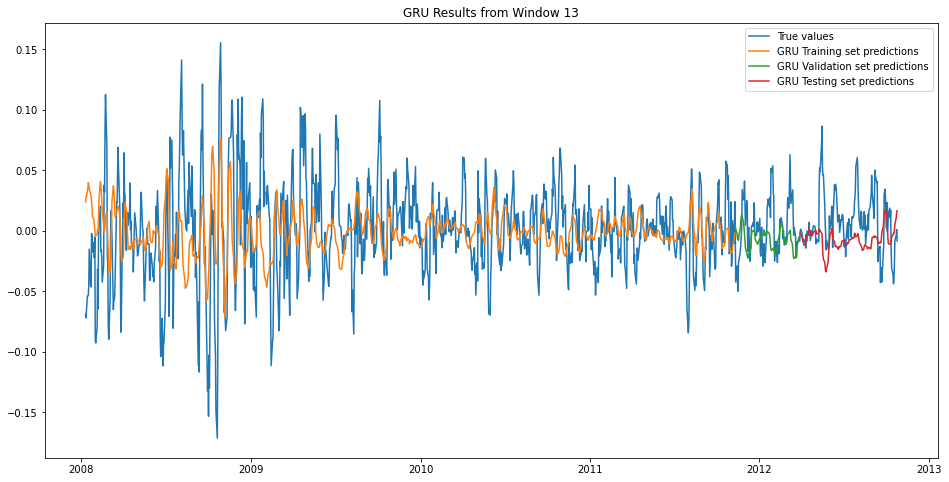

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0010832849319450657
RMSE = 0.03291329415213654
MAE = 0.02415274001387168
R-Squared = 0.1461653398608025

Results on Validation set: 
MSE = 0.0005197590125215965
RMSE = 0.022798223889627815
MAE = 0.01795583581746384
R-Squared = -0.014124345882328138

Results on Testing set: 
MSE = 0.0007424697121592921
RMSE = 0.02724829741762395
MAE = 0.020882640181220536
R-Squared = -0.05944635002985943



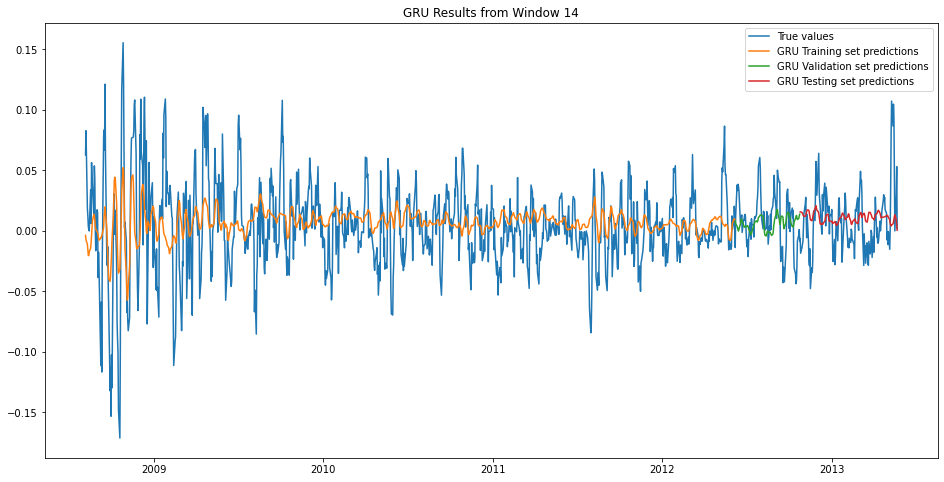

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0007563552428632512
RMSE = 0.027501913440036337
MAE = 0.02078059777677897
R-Squared = -0.02872199983778434

Results on Validation set: 
MSE = 0.0008158947512108266
RMSE = 0.02856387143247264
MAE = 0.01997742729430122
R-Squared = -0.0755607868320538

Results on Testing set: 
MSE = 0.0010058259435855174
RMSE = 0.03171475908130972
MAE = 0.025087167637701035
R-Squared = -0.07696325752589206



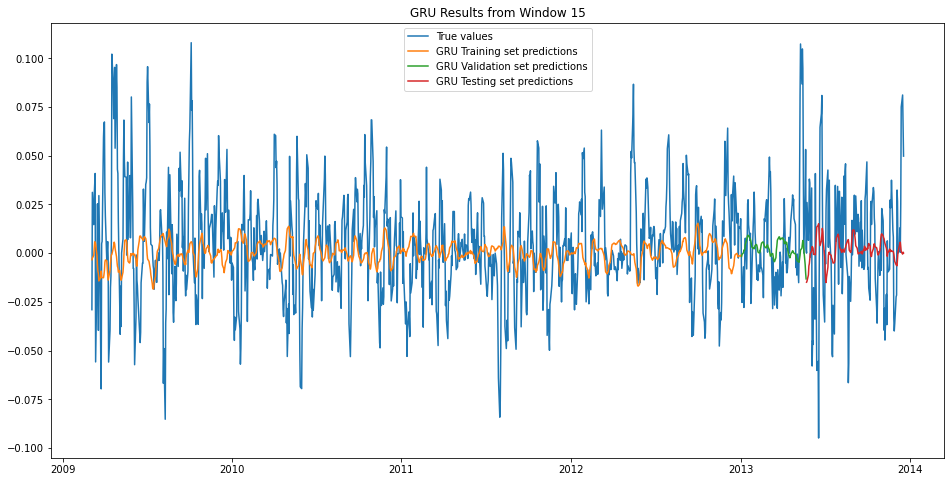

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0006474904686638285
RMSE = 0.025445834013917257
MAE = 0.019232565528392212
R-Squared = 0.03596048070259861

Results on Validation set: 
MSE = 0.0006748461329781403
RMSE = 0.02597780077254694
MAE = 0.020482513077700708
R-Squared = 0.038450435886277834

Results on Testing set: 
MSE = 0.0013624399258982572
RMSE = 0.03691124389529913
MAE = 0.02732586633138246
R-Squared = -0.26491045460944007



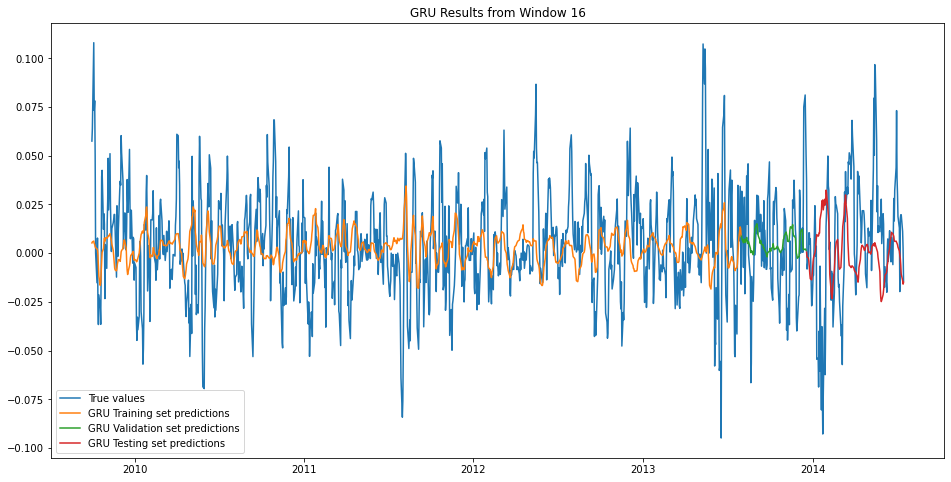

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0006932229613585016
RMSE = 0.026329127622435604
MAE = 0.019989023255615596
R-Squared = 0.009045143268743505

Results on Validation set: 
MSE = 0.000922306283320162
RMSE = 0.03036949593457491
MAE = 0.02299802648101055
R-Squared = -0.19554036779060402

Results on Testing set: 
MSE = 0.0007301404176770944
RMSE = 0.027021110592962208
MAE = 0.020505976867838154
R-Squared = -0.06982116996549714



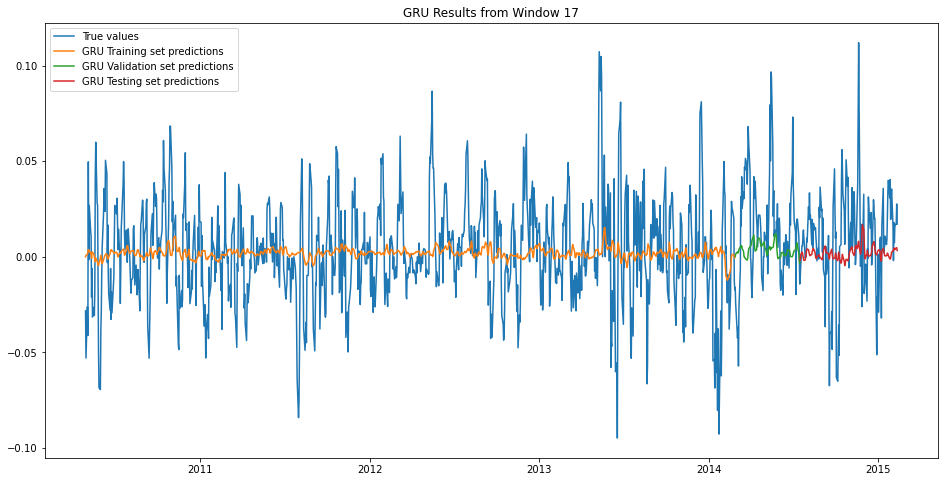

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0007011519740645711
RMSE = 0.02647927442481329
MAE = 0.019632008919957394
R-Squared = 0.0016866650460923838

Results on Validation set: 
MSE = 0.0007617260964551314
RMSE = 0.02759938579851246
MAE = 0.020549638620475943
R-Squared = 0.003991446471195204

Results on Testing set: 
MSE = 0.0010349757645766477
RMSE = 0.03217103922127241
MAE = 0.024973702068508553
R-Squared = -0.08845700004474821



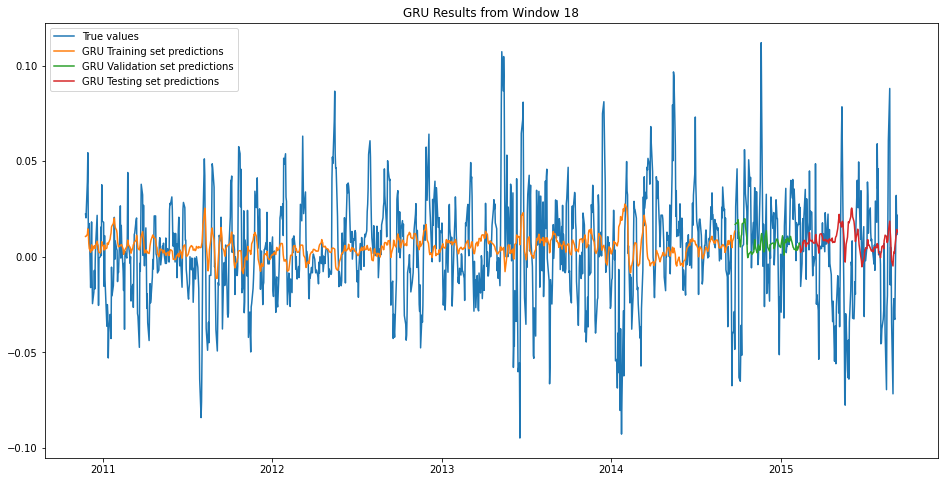

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0007348346202176935
RMSE = 0.027107833189277477
MAE = 0.02038705680812644
R-Squared = 0.014098092985348698

Results on Validation set: 
MSE = 0.0012875581800130937
RMSE = 0.03588256094557764
MAE = 0.028921226893726098
R-Squared = -0.07111044433573066

Results on Testing set: 
MSE = 0.001402623437042431
RMSE = 0.0374516146119554
MAE = 0.029812792609218867
R-Squared = -0.08381466295617179



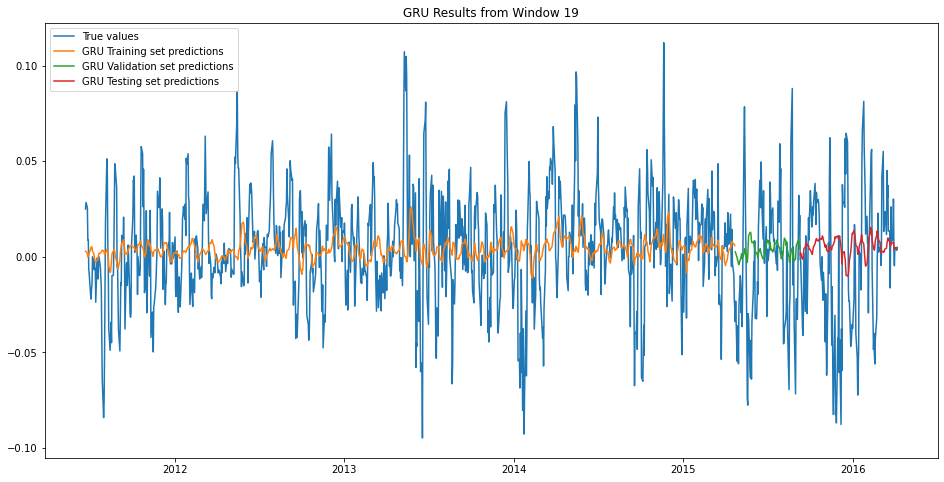

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0008305997449462738
RMSE = 0.02882012742765503
MAE = 0.021814809220155006
R-Squared = -0.027995046612836028

Results on Validation set: 
MSE = 0.0016046911524980115
RMSE = 0.040058596486871725
MAE = 0.031985880248727415
R-Squared = -0.025921654049254617

Results on Testing set: 
MSE = 0.0011150397994397815
RMSE = 0.03339221165840594
MAE = 0.02673604241730277
R-Squared = -0.04675113526457175



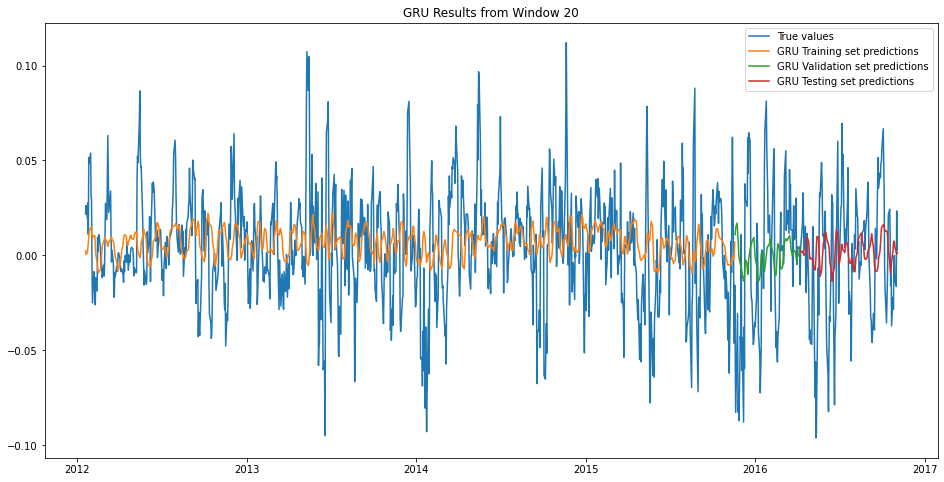

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.000988285776936568
RMSE = 0.03143701285008752
MAE = 0.023783583762671475
R-Squared = -0.013105608898690058

Results on Validation set: 
MSE = 0.0008045964322486298
RMSE = 0.02836540907952201
MAE = 0.02249174847584727
R-Squared = 0.05233880023654125

Results on Testing set: 
MSE = 0.002023305812553091
RMSE = 0.044981171756114706
MAE = 0.030817611895077757
R-Squared = -0.30160586539236744



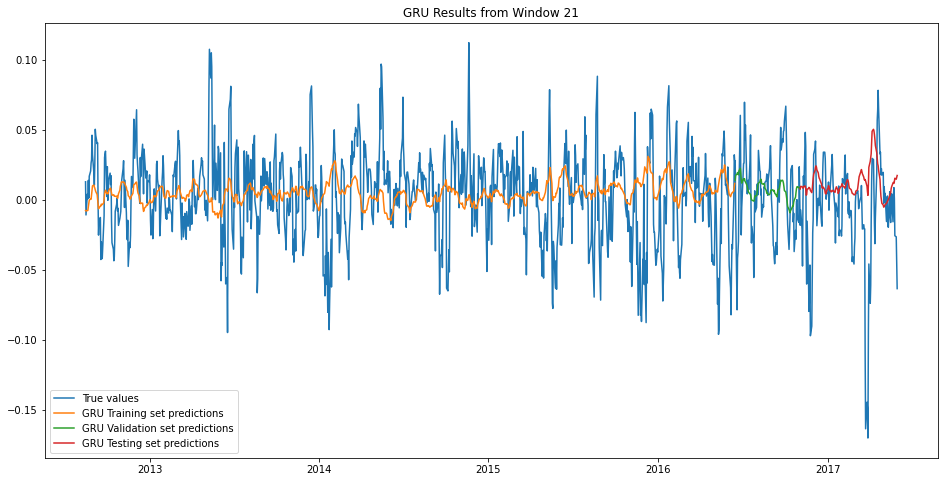

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0010367324992199673
RMSE = 0.032198330689959184
MAE = 0.024561573885191826
R-Squared = 0.004908902481677968

Results on Validation set: 
MSE = 0.002008122722655113
RMSE = 0.04481208232893349
MAE = 0.028153835786330347
R-Squared = -0.1773927214537312

Results on Testing set: 
MSE = 0.001260895034484856
RMSE = 0.035509083830547586
MAE = 0.02659988882286719
R-Squared = -0.04265117745430458



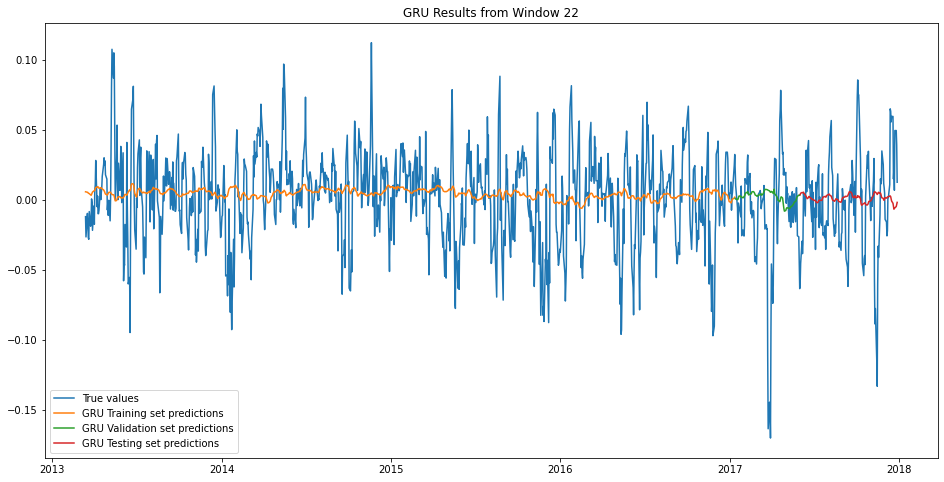

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0010903225384120147
RMSE = 0.03302003238054158
MAE = 0.025466804885913057
R-Squared = 0.010939986636812171

Results on Validation set: 
MSE = 0.0014335983864897906
RMSE = 0.03786288930456563
MAE = 0.02792196548899776
R-Squared = 0.042715194987786975

Results on Testing set: 
MSE = 0.0012374214713577903
RMSE = 0.03517700202344978
MAE = 0.025703430396836764
R-Squared = -0.10711355410952961



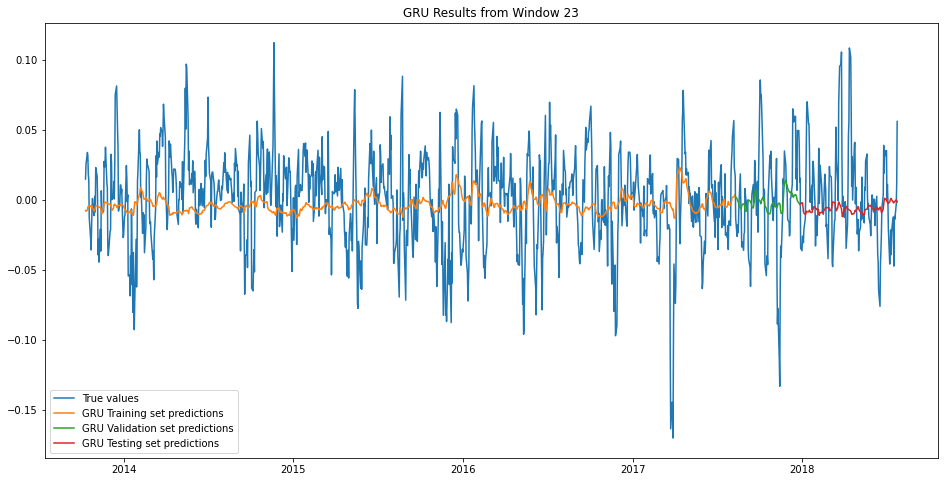

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.001224281164132955
RMSE = 0.034989729409256015
MAE = 0.027050572095155587
R-Squared = -0.08337381293568558

Results on Validation set: 
MSE = 0.0015002614569245088
RMSE = 0.038733208709381524
MAE = 0.026973726667866158
R-Squared = -0.1362540302215256

Results on Testing set: 
MSE = 0.001421522846860948
RMSE = 0.037703088028183424
MAE = 0.026567104041359584
R-Squared = -0.056316351373369766



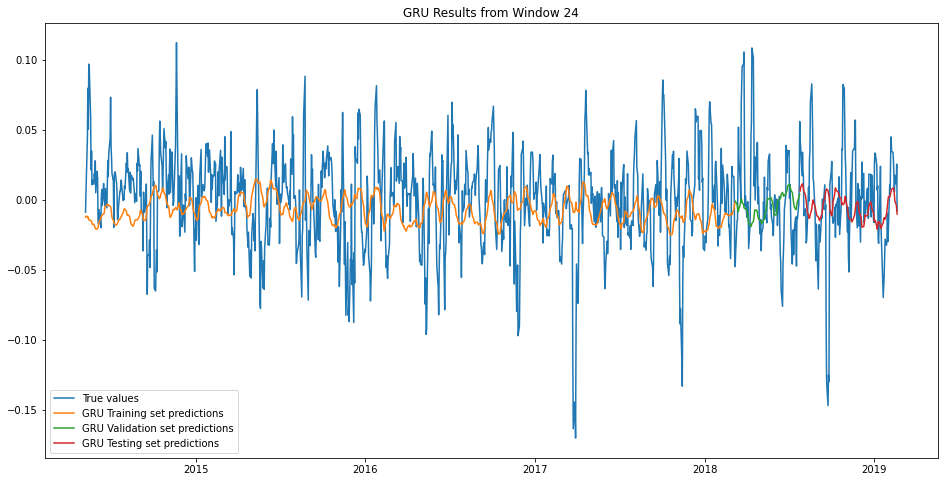

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4918

Results on Training set: 
MSE = 0.0012904869154049974
RMSE = 0.03592334777557623
MAE = 0.026599072362515977
R-Squared = -0.041890755476051256

Results on Validation set: 
MSE = 0.0007341226018476568
RMSE = 0.027094696932197945
MAE = 0.021967122320379544
R-Squared = 0.07427315060711814

Results on Testing set: 
MSE = 0.0024039439963110497
RMSE = 0.049030031575668494
MAE = 0.035091565642151316
R-Squared = -0.2023255752559152



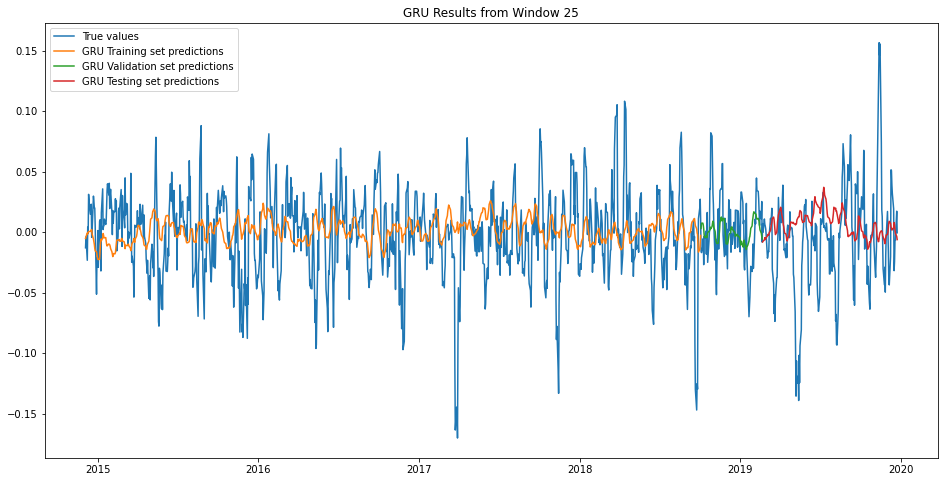

In [10]:
#Declaring model parameters
sequencelength = 200
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.0014722591200107835
RMSE = 0.03837002892898028
MAE = 0.028325684852279494
R-Squared = -0.12686863997307896

GRU model results on the Testing set
MSE = 0.0014319890754644485
RMSE = 0.037841631511662505
MAE = 0.028076488314520198
R-Squared = -0.09564303190662282

Naive model results on the Testing set
MSE = 0.0027250024032611747
RMSE = 0.05220155556361491
MAE = 0.03950495289569143
R-Squared = -1.101569776088264

Drift model results on the Testing set
MSE = 0.0033459889674566923
RMSE = 0.057844524092230995
MAE = 0.04324864101841685
R-Squared = -1.5804855352480969



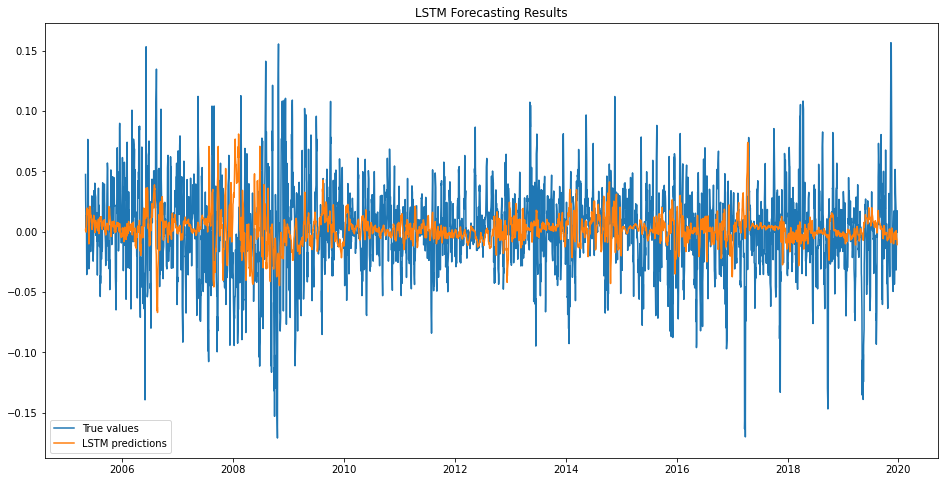

In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

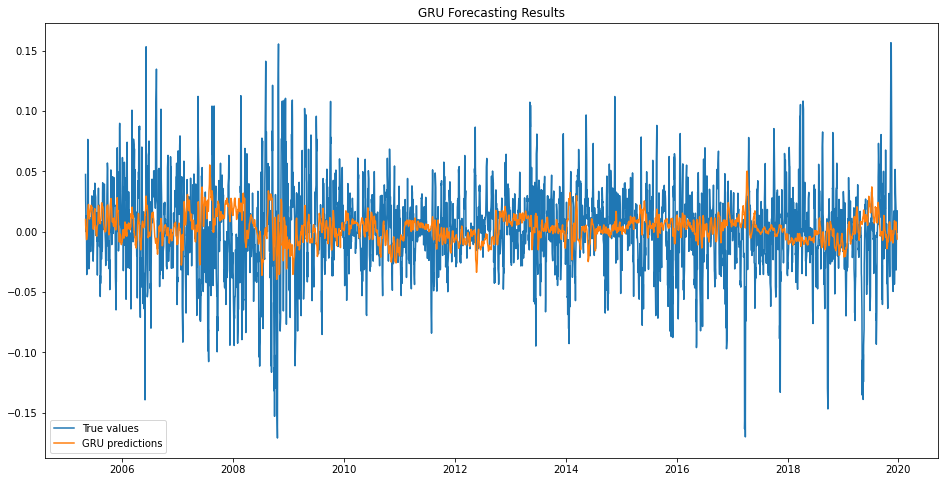

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

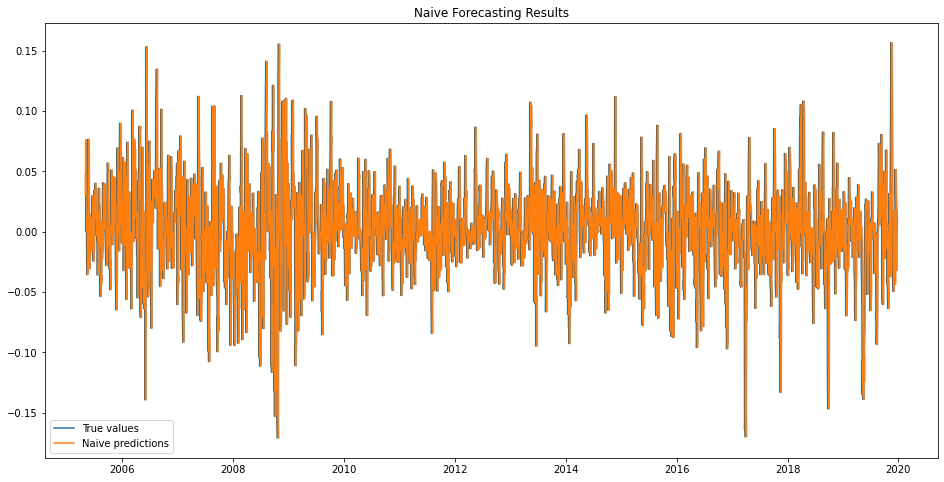

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

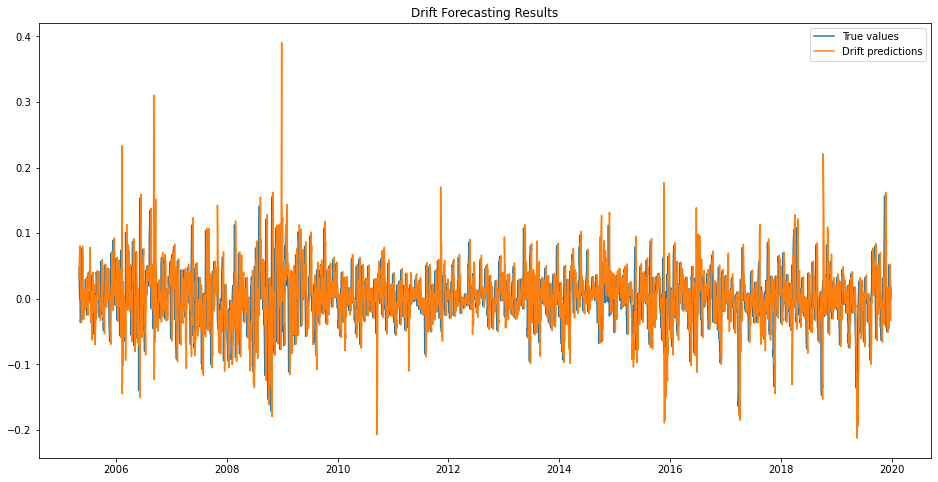

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['NTC LSTM'] = lstm_predictions[-numpreds:]
savePredictions['NTC GRU'] = gru_predictions[-numpreds:]
savePredictions['NTC Naive'] = naive_predictions[-numpreds:]
savePredictions['NTC Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./NTC_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

NTC LSTM   NTC GRU  NTC Naive  NTC Drift
Date                                                
2005-05-05  0.001385  0.010080   0.029905   0.032194
2005-05-06  0.002585  0.004871   0.050844   0.054146
2005-05-09 -0.000398  0.000644   0.076161   0.080673
2005-05-10  0.006779 -0.003422   0.074623   0.079016
2005-05-11  0.012816 -0.005693   0.049540   0.052685